# Notebook for the making of Figure 8 and 9: Reconstructions and Strain

In [11]:
import numpy as np
import pylab as plt
from numpy.fft import fftshift, ifftshift
import tensorflow as tf 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from predict_phase_2D_utilities import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from functions import*
from interpolation_functions import*
from line_cross_standard_utilities import *
from line_cross_tensorflow_prediction_utilities import *

plt.rcParams['image.cmap'] = 'plasma'

2.2.0
Num GPUs Available:  1


In [12]:
from tensorflow.keras import losses
keras.losses.custom_loss = MyLoss_noisy


In [40]:
def add_colorbar_subplots(fig, ax, imgs):
    c = 0   
    for axe,im in zip(ax.flatten(), imgs):
        
        divider = make_axes_locatable(axe)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.ax.tick_params(labelsize=20)
        
    return

In [14]:
def crop_3d_array(array, crop_array):
    array_crop = array[array.shape[0]//2-crop_array[0]//2 : array.shape[0]//2+crop_array[0]//2,
                       array.shape[1]//2-crop_array[1]//2 : array.shape[1]//2+crop_array[1]//2,
                       array.shape[2]//2-crop_array[2]//2 : array.shape[2]//2+crop_array[2]//2]
    return array_crop

# Load the data

In [15]:
Fexp = np.load('path_to_obj1') # ground truth Diffracted amplitude 
data = np.abs(Fexp)**2. # diffracted intensity


In [16]:
def add_cross_gap_3D(Fexp, gap_size = None, gap_position = None, min_distance_from_center = 0): 
                                        
    
    off = 20
    center_position = Fexp.shape[1] / 2.
    random_list = np.arange(-gap_size//2, int(round(center_position-min_distance_from_center)))
    random_list = np.concatenate((random_list, 
                          np.arange(int(round(center_position+min_distance_from_center)), Fexp.shape[1]+gap_size//2)))
    
    if gap_position is None:
        gap_position = np.random.choice(random_list)

    mask_ver = np.zeros(Fexp.shape)
    mask_hor = np.zeros(Fexp.shape)

    gap_start = gap_position - gap_size // 2
    gap_end = gap_position + gap_size // 2
    if gap_size % 2 > 0: # se e' dispari
        gap_end += 1
        
    mask_ver[:, gap_start:gap_end, :] = 1  # xz plane

    mask_hor[gap_start:gap_end,:,:] = 1    # yz plane
    
    mask = mask_ver + mask_hor
    mask[mask>1] = 1
    
    Fexp_masked = Fexp*(1.-mask)
    
    return mask

In [ ]:
import tensorflow as tf 
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gapsizes = [3,6,9,12]
prediction = np.zeros((len(gapsizes), data.shape[0], data.shape[1], data.shape[2]))
prediction_linear = np.zeros_like(prediction)

for i, gapsize in zip(range(len(gapsizes)), gapsizes):
    
    mask = add_cross_gap_3D(data, gap_size = gapsize, gap_position = 190, min_distance_from_center = 0)
    data_masked_linear = data*(1.-mask)
    
    data_masked, maxi_rescale1, maxi_rescale2 = data_preprocessing(data_masked_linear)
    gap_params = find_gap_parameters(mask, verbose=False)
    
    model_path = 'path_to_model_i-px'
    
    print('model path :', model_path)
    keras.losses.custom_loss = MyLoss_noisy

    if os.path.exists(model_path):
        print('This gap size model exists')

        model = tf.keras.models.load_model(model_path, custom_objects=None, compile=False)
        print('Models loading done.')
    else:
        print('Error, this gap size model doesn\'t exits yet')


    skip_pixels = 0
    prediction[i] = gap_prediction(data_masked, mask, gap_params, model, skip_pixels=skip_pixels)
    prediction_linear[i] = post_processing_prediction(prediction[i],maxi_rescale1, maxi_rescale2)
    
    print('\n Completed Inpainting n. ',i)
        

2.2.0
Num GPUs Available:  1
model path : /data/projects/id01ml/SavedModels/3D_inpainting_portions32_3px_cross/
This gap size model exists
Models loading done.
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 327 327 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 311 311 
 Completed Inpainting n.  0
model path : /data/projects/id01ml/SavedModels/3D_inpainting_portions32_6px_cross/
This gap size model exists
Models loading done.
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 

# Object Reconstruction - 9px case


In [20]:


from ComputeStrain_Ewen import*

def compute_Jerome_strain(obj):
    module, phase = get_cropped_module_phase(obj, threshold_module=.4, crop=False)
    gradient = EB_custom_gradient(phase, voxel_sizes=[40,40,40])
    
    # I put same pixel size along all direction. Only axis 1 matters anyway

    strain = gradient[1]/2.787253350191427 # Gradient divided by by the Bragg wavevector modulus
    
    return strain

In [23]:
obj = ifftshift(ifftn(fftshift(Fexp)))

mask = add_cross_gap_3D(data, gap_size = 9, gap_position = 190, min_distance_from_center = 0)
Fexp_masked = np.sqrt(data*(1.0-mask)) * np.exp(1.0j*np.angle(Fexp)) # Masked diffracted amplitude
obj_masked = ifftshift(ifftn(fftshift(Fexp_masked)))

Fexp_pred = np.sqrt(prediction_linear[2]) * np.exp(1.0j*np.angle(Fexp)) # Predicted diffracted amplitude
obj_pred = ifftshift(ifftn(fftshift(Fexp_pred)))


# Choose the case for 9 px gap

In [37]:
threshold_module = .4

mod_gt = np.abs(obj)
mod_mask = np.abs(obj_masked)
mod_dl = np.abs(obj_pred)


phi_gt = np.angle(obj)
phi_gt[mod_gt <= threshold_module*np.max(mod_gt)] = np.nan

phi_mask = np.angle(obj_masked)
phi_mask[mod_mask <= threshold_module*np.max(mod_mask)] = np.nan

phi_dl = np.angle(obj_pred)
phi_dl[mod_dl <= threshold_module*np.max(mod_dl)] = np.nan


# Make Figure 8

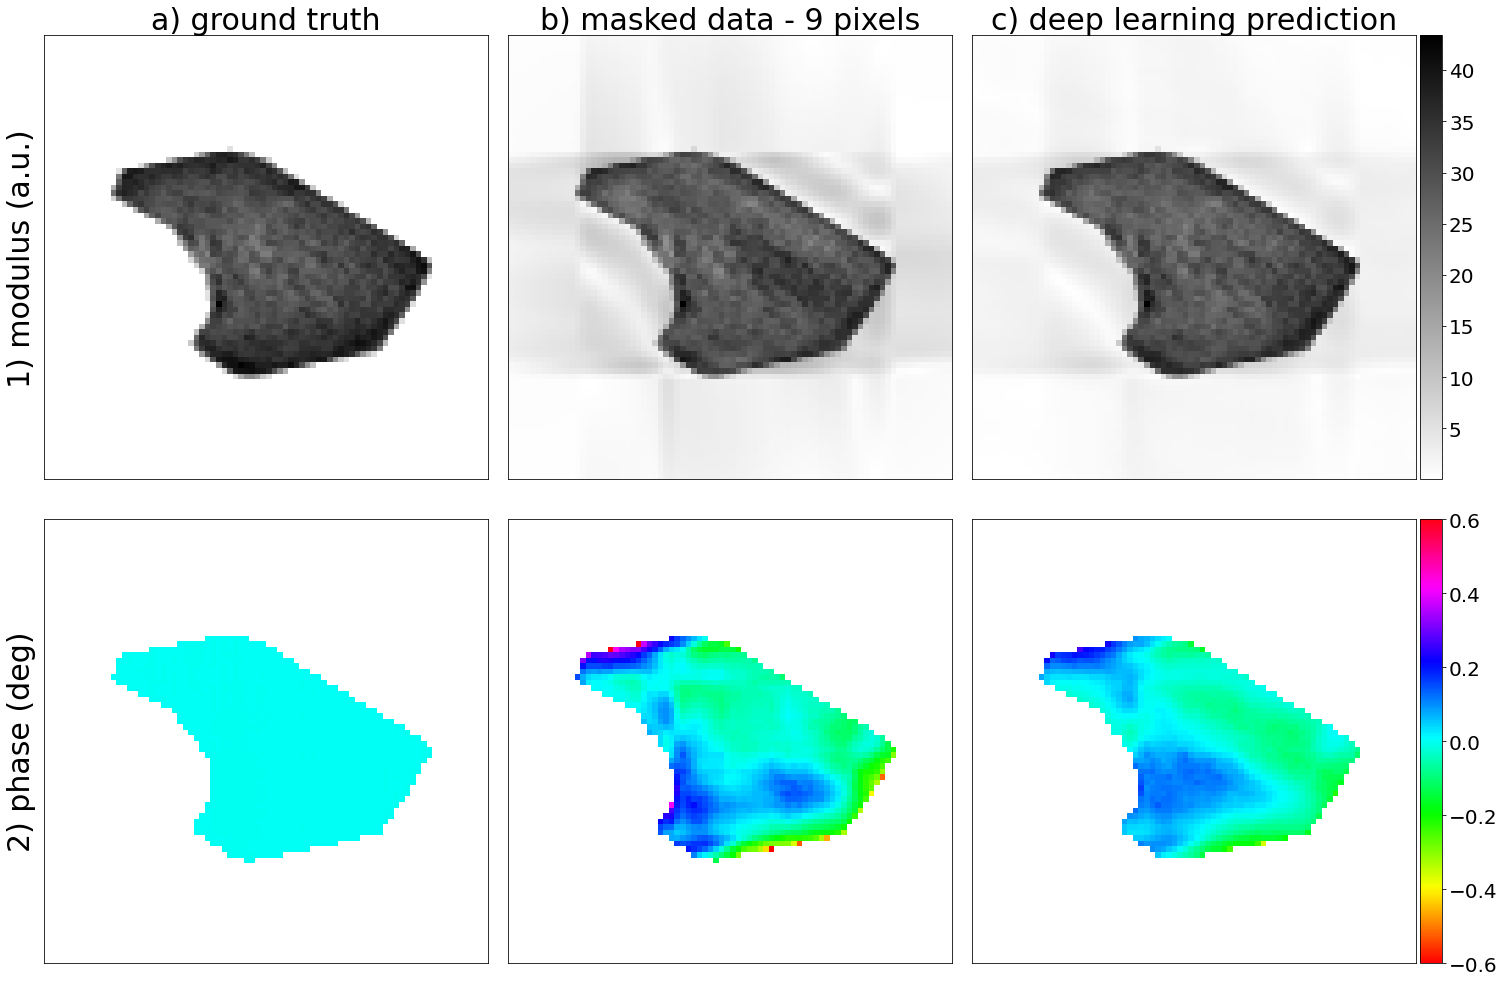

In [41]:
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 7*nrow))


img = []
img.append(ax[0,0].matshow(mod_gt[171-40:171+40, 179-40:179+40,data.shape[2]//2] , cmap='gray_r'))
ax[0,0].set_title('a) ground truth', fontsize=30)
ax[0,0].set_ylabel('1) modulus (a.u.)', fontsize=30)

img.append(ax[0,1].matshow(mod_mask[171-40:171+40, 179-40:179+40,data.shape[2]//2], cmap='gray_r'))
ax[0,1].set_title('b) masked data - 9 pixels', fontsize=30)

img.append(ax[0,2].matshow(mod_dl[171-40:171+40, 179-40:179+40,data.shape[2]//2], cmap='gray_r'))
ax[0,2].set_title('c) deep learning prediction', fontsize=30)

img.append(ax[1,0].matshow(phi_gt[171-40:171+40, 179-40:179+40,data.shape[2]//2], cmap='hsv', vmin=-0.6, vmax=0.6))
ax[1,0].set_ylabel('2) phase (deg)', fontsize=30)

img.append(ax[1,1].matshow(phi_mask[171-40:171+40, 179-40:179+40,data.shape[2]//2], cmap='hsv', vmin=-0.6, vmax=0.6))

img.append(ax[1,2].matshow(phi_dl[171-40:171+40, 179-40:179+40,data.shape[2]//2], cmap='hsv', vmin=-0.6, vmax=0.6))

add_colorbar_subplots(fig, ax, img)

for i, j in zip([0,0,0,1,1,1], [0,1,2,0,1,2]):
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

fig.tight_layout()


# Make Figure 9

In [ ]:
# THIS CELL CALCULATES THE AVERAGE STRAIN AND THE STD FOR ALL THE PREDICTIONS

crop_array = [140,140,140]

threshold_module = .4

avg_pred = np.zeros((5))
rmse_pred = np.zeros((5))

avg_pred_yy = np.zeros((5))
rmse_pred_yy = np.zeros((5))

avg_gt = 0
rmse_gt = 0

strains_pred = np.zeros((len(files),140,140,140))

for i in range(len(gapsizes)):

    prediction_linear = prediction[i]
    
    Fexp_pred = np.sqrt(prediction_linear) * np.exp(1.0j*np.angle(Fexp)) # Predicted diffracted amplitude
    obj_pred = ifftshift(ifftn(fftshift(Fexp_pred)))
    obj_pred = crop_3d_array(obj_pred, crop_array)

    strain = compute_Jerome_strain(obj_pred)
    strains_pred[i] = strain
    a = np.isnan(strain)
    strain[a] = 0
    avg_pred[i] = np.mean(strain)
    rmse_pred[i] = np.sqrt(np.mean((strain - np.zeros((strain.shape)))**2))
    
    avg_pred_yy[i] = np.sum(np.mean(strain, axis=1))
    rmse_pred_yy[i] = np.sum(np.sqrt(np.mean((strain - np.zeros((strain.shape)))**2, axis = 1)))


avg_pred = np.roll(avg_pred, 1)
avg_pred[0] = avg_gt

rmse_pred = np.roll(rmse_pred, 1)
rmse_pred[0] = rmse_gt

avg_pred_yy = np.roll(avg_pred_yy, 1)
avg_pred_yy[0] = avg_gt

rmse_pred_yy = np.roll(rmse_pred_yy, 1)
rmse_pred_yy[0] = rmse_gt


In [ ]:
# THIS CELL CALCULATES THE AVERAGE STRAIN AND THE STD FOR ALL THE MASKED DATA

gap_position = 190
avg_gt = 0
std_gt = 0
avg_mask = np.zeros((5))
rmse_mask = np.zeros((5))

avg_mask_yy = np.zeros((5))
rmse_mask_yy = np.zeros((5))

strains_masked = np.zeros((len(gapsize),140,140,140))
threshold_module = .4

i = 0

for gap in gapsizes:
    
    mask = add_cross_gap3D(data, gap = gapsize, gap_position = 190, min_distance_from_center = 0)
    Fexp_masked = Fexp*(1-mask)
    
    obj_masked = ifftshift(ifftn(fftshift(Fexp_masked)))
    obj_masked = crop_3d_array(obj_masked, crop_array)
    
    strain = compute_Jerome_strain(obj_masked)
    strains_masked[i] = strain
    nans = np.isnan(strain)
    strain[nans] = 0
    avg_mask[i] = np.mean(strain)
    rmse_mask[i] = np.sqrt(np.mean((strain - np.zeros((strain.shape)))**2))
    
    avg_mask_yy[i] = np.sum(np.mean(strain, axis=1))
    rmse_mask_yy[i] = np.sum(np.sqrt(np.mean((strain - np.zeros((strain.shape)))**2, axis = 1)))
    
    i += 1
    
    
avg_mask = np.roll(avg_mask, 1)
avg_mask[0] = avg_gt

rmse_mask = np.roll(rmse_mask, 1)
rmse_mask[0] = rmse_gt

avg_mask_yy = np.roll(avg_mask_yy, 1)
avg_mask_yy[0] = avg_gt

rmse_mask_yy = np.roll(rmse_mask_yy, 1)
rmse_mask_yy[0] = rmse_gt

In [ ]:
x = np.array([0,3,6,9,12])

plt.figure(figsize = (15,10))
plt.plot(x, rmse_mask*100, marker='o', linestyle='dashed', linewidth=3, markersize=15)
plt.plot(x, rmse_pred*100, marker='o', linestyle='dashed', linewidth=3, markersize=15)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.legend(['With gap', 'With DL predicted gap'], fontsize = 26)
plt.xlabel('Gap width (pixels)', fontsize = 28)
plt.ylabel('RMSE (%)', fontsize = 28)
